# LSTM + Decision Tree Integration Demo

This notebook demonstrates a full pipeline for hard drive failure prediction using both LSTM (deep learning) and Decision Tree (CT) models.

You will:
- Train and test the LSTM model
- Train and test the Decision Tree model on raw data
- Generate LSTM predictions for all drives
- Test a random drive using the LSTM model
- Feed the LSTM results into the Decision Tree and analyze the outcome

**Requirements:**  
- All dependencies installed (see `requirements.txt`)
- Data available in `data`
- LSTM and CT code available in `notebooks/LSTM/smart.py` and `notebooks/CT/CT.py`


In [1]:
# Step 1: Setup and Imports

import os
import sys
from typing import Optional
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib
import json
from datetime import datetime
from sklearn.metrics import classification_report
import random
from joblib import load


# Add project root and submodules to sys.path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "notebooks/LSTM"))
sys.path.append(os.path.join(project_root, "notebooks/CT"))

import notebooks.LSTM.smart as smart
import notebooks.CT.CT as CT
from notebooks.LSTM.smart import Net


### Setup

In [2]:
ct_data_path = "../data"
lstm_data_path = "../data/data_test"
days_to_train = 3
days_to_predict = 2
verbose = True

#LSTM parameters
num_features = 12
n_neurons = 4
num_epochs = 1
learning_rate = 0.001

#CT parameters
ct_depth = 100
ct_leaf = 15

In [3]:

# Set device for torch: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 2: Load the data to train the models

In [4]:
min_sequence_length = days_to_train + days_to_predict
print(f'Using device: {device}')


Using device: cuda


In [5]:

print("🔄 Loading and splitting data to prevent data leakage...")


train_loader, test_loader = smart.load_data(root=lstm_data_path,
                                        train_ratio=0.8, 
                                        min_sequence_length=min_sequence_length,
                                        input_len=days_to_train,
                                        label_len=days_to_predict,
                                        verbose=verbose)


🔄 Loading and splitting data to prevent data leakage...
[DriveDataLoader] Found 0 subfolders in ../data/data_test.


Loading CSV files:  17%|█▋        | 1/6 [00:03<00:18,  3.71s/it]

Loaded ../data/data_test\2024-10-01.csv with shape (292679, 15)


Loading CSV files:  33%|███▎      | 2/6 [00:07<00:14,  3.66s/it]

Loaded ../data/data_test\2024-10-02.csv with shape (292648, 15)


Loading CSV files:  50%|█████     | 3/6 [00:10<00:10,  3.59s/it]

Loaded ../data/data_test\2024-10-03.csv with shape (292662, 15)


Loading CSV files:  67%|██████▋   | 4/6 [00:14<00:06,  3.48s/it]

Loaded ../data/data_test\2024-10-04.csv with shape (292694, 15)


Loading CSV files:  83%|████████▎ | 5/6 [00:17<00:03,  3.43s/it]

Loaded ../data/data_test\2024-10-05.csv with shape (292693, 15)


Loading CSV files: 100%|██████████| 6/6 [00:20<00:00,  3.47s/it]

Loaded ../data/data_test\2024-10-06.csv with shape (292683, 15)
[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized', 'smart_9_normalized', 'smart_187_normalized', 'smart_189_normalized', 'smart_190_normalized', 'smart_195_normalized', 'smart_197_normalized', 'smart_197_raw']


[DriveDataLoader] Loaded 1756059 rows from all CSV files. DataFrame shape: (1756059, 15)
[DriveDataLoader] Found 292766 unique drives.
[DriveDataLoader] Filtering drives with minimum 5 days...
[DriveDataLoader] Valid drives (>= 5 days): 292624
[DriveDataLoader] Invalid drives (< 5 days): 142
[DriveDataLoader] Sequence length distribution of invalid drives:
[DriveDataLoader]   {1: np.int64(19), 2: np.int64(28), 3: np.int64(54), 4: np.int64(41)}
[DriveDataLoader] Split: 234099 drives for training, 58525 drives for testing.
[DriveDataLoader] Train ratio: 80.00%
[DriveDataLoader] Final dataset: 1755658 rows from 292624 valid drives.
[DriveDataLoader] Sample TRAIN drive 2GG3UKHD: 6 rows, dates 2024-10-01 to 2024-10-06
[DriveDataLoader] Sample TEST drive ZL2D6FJZ: 6 rows, dates 2024-10-01 to 2024-10-06
[DriveDataLoader] ✅ Verified: No drive overlap between train and test sets.

[DriveDataLoader] 📊 Sample drive verification:
[DriveDataLoader] 🚂 TRAIN sample - Drive 2GG3UKHD:
[DriveDataLoader]

# Step 3: Train the LSTM model

In [6]:
# Check if trained model exists
model_path = 'models/LSTM/lstm_model.pth'

model, model_exists = smart.train_model(features = num_features,
            n_neurons = n_neurons,
            model_path = model_path,
            days_to_predict = days_to_predict,
            days_to_train = days_to_train,
            train_loader = train_loader,
            test_loader = test_loader,
            test_existing = False,
            learning_rate = learning_rate,
            num_epochs = num_epochs)


shape: (torch.Size([3, 3, 12]), torch.Size([3, 2, 12]))
No saved model found. Training from scratch...


Training Progress: 100%|██████████| 1/1 [13:43<00:00, 823.36s/it]


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 59294.270788
Epoch 1/1 - Train Loss: 71071.906456, Val Loss: 59294.270788
✅ Final loss curve saved to models/LSTM\final_loss.png


## Step 4: Generate predictions 

In [7]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_targets = []

print("Generating final predictions...")
with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc="Generating predictions"):
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        predictions = model(test_data)
        test_predictions.append(predictions.cpu().numpy())
        test_targets.append(test_labels.cpu().numpy())

# Concatenate all predictions and targets
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

Generating final predictions...


Generating predictions: 100%|██████████| 19509/19509 [01:24<00:00, 230.20it/s]


# Step 5: Plot the results

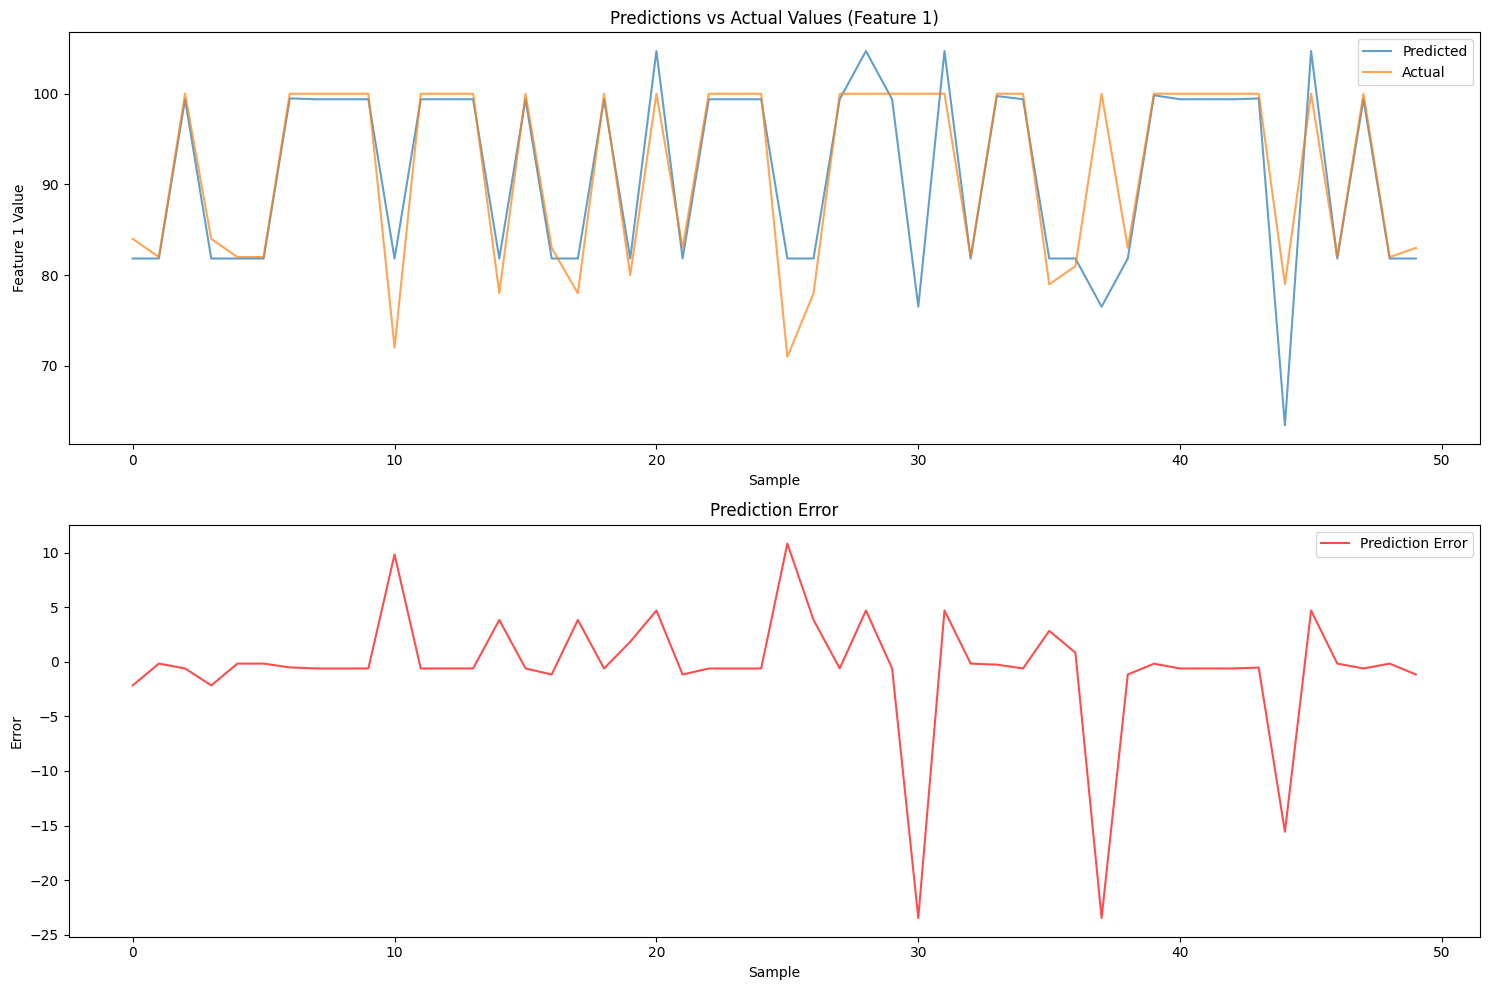

In [8]:
# Plot predictions vs actual values for the first feature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot first few samples for visualization
num_samples_to_plot = min(50, len(test_predictions))
x = np.arange(num_samples_to_plot)

ax1.plot(x, test_predictions[:num_samples_to_plot, 0, 0], label='Predicted', alpha=0.7)
ax1.plot(x, test_targets[:num_samples_to_plot, 0, 0], label='Actual', alpha=0.7)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Feature 1 Value")
ax1.set_title("Predictions vs Actual Values (Feature 1)")
ax1.legend()

# Plot prediction error
error = test_predictions[:num_samples_to_plot, 0, 0] - test_targets[:num_samples_to_plot, 0, 0]
ax2.plot(x, error, label='Prediction Error', color='red', alpha=0.7)
ax2.set_xlabel("Sample")
ax2.set_ylabel("Error")
ax2.set_title("Prediction Error")
ax2.legend()
plt.tight_layout()

## Step 4: Train and Test the Decision Tree (CT) on Raw Data

We will now train and test the Decision Tree model using the raw SMART data.

### Step 4.1: Load the data to train the Decision Tree model

In [9]:
data = CT.importdata(ct_data_path)

# Split dataset and apply SMOTE
X, Y, X_train_res, X_test, y_train_res, y_test = CT.splitdataset(data)

Processing subfolders: 100%|██████████| 5/5 [24:41<00:00, 296.30s/it]

Dataset Length:  28908
Dataset Shape:  (28908, 13)
Dataset:          failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
244236    False               100.0               100.0               100.0   
299107    False               100.0                84.0               100.0   
106180    False               100.0                95.0               100.0   
78820     False                84.0                93.0               100.0   
177056    False               100.0               100.0               100.0   

        smart_5_raw  smart_7_normalized  smart_9_normalized  \
244236          0.0               100.0                42.0   
299107          0.0               100.0               100.0   
106180          0.0               100.0               100.0   
78820           0.0                90.0                90.0   
177056          0.0               100.0                26.0   

        smart_187_normalized  smart_189_normalized  smart_190_normalized  \
244236   


c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Train both decision tree models

In [10]:
print("\nTraining Decision Tree with Gini criterion...")
clf_gini = CT.train_using_gini(X_train_res, X_test, y_train_res, depth=ct_depth, leaf=ct_leaf)


Training Decision Tree with Gini criterion...


In [11]:
print("\nTraining Decision Tree with Entropy criterion...")
clf_entropy = CT.train_using_entropy(X_train_res, X_test, y_train_res, depth=ct_depth, leaf=ct_leaf)


Training Decision Tree with Entropy criterion...


### Test models

In [12]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)


Results Using Gini Index:
Predicted values:
[ True False  True ... False  True False]


In [13]:
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini")

Confusion Matrix:  [[6815  372]
 [ 295 1191]]
Accuracy :  92.3094661593451
Report :                precision    recall  f1-score   support

       False       0.96      0.95      0.95      7187
        True       0.76      0.80      0.78      1486

    accuracy                           0.92      8673
   macro avg       0.86      0.87      0.87      8673
weighted avg       0.92      0.92      0.92      8673

FP:  372.0
FN:  295.0
TP:  1191.0
TN:  6815.0
TPR:  0.8014804845222072
TNR:  0.9482398775566996
PPV:  0.761996161228407
NPV:  0.9585091420534458
FPR:  0.0517601224433004
FNR:  0.19851951547779273
FDR:  0.2380038387715931
ACC:  0.923094661593451
❌ New gini model accuracy (0.9231) not better than previous best (0.9316)


In [14]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini")


Results Using Gini Index:
Predicted values:
[ True False  True ... False  True False]
Confusion Matrix:  [[6815  372]
 [ 295 1191]]
Accuracy :  92.3094661593451
Report :                precision    recall  f1-score   support

       False       0.96      0.95      0.95      7187
        True       0.76      0.80      0.78      1486

    accuracy                           0.92      8673
   macro avg       0.86      0.87      0.87      8673
weighted avg       0.92      0.92      0.92      8673

FP:  372.0
FN:  295.0
TP:  1191.0
TN:  6815.0
TPR:  0.8014804845222072
TNR:  0.9482398775566996
PPV:  0.761996161228407
NPV:  0.9585091420534458
FPR:  0.0517601224433004
FNR:  0.19851951547779273
FDR:  0.2380038387715931
ACC:  0.923094661593451
❌ New gini model accuracy (0.9231) not better than previous best (0.9316)


In [15]:
print("\n" + "="*50)
print("Results Using Entropy:")
print("="*50)
y_pred_entropy = CT.prediction(X_test, clf_entropy)



Results Using Entropy:
Predicted values:
[ True False  True ... False  True False]


In [16]:
CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")

Confusion Matrix:  [[6819  368]
 [ 287 1199]]
Accuracy :  92.44782658826243
Report :                precision    recall  f1-score   support

       False       0.96      0.95      0.95      7187
        True       0.77      0.81      0.79      1486

    accuracy                           0.92      8673
   macro avg       0.86      0.88      0.87      8673
weighted avg       0.93      0.92      0.93      8673

FP:  368.0
FN:  287.0
TP:  1199.0
TN:  6819.0
TPR:  0.806864064602961
TNR:  0.9487964380130792
PPV:  0.7651563497128271
NPV:  0.9596115958345061
FPR:  0.05120356198692083
FNR:  0.19313593539703902
FDR:  0.23484365028717294
ACC:  0.9244782658826243
❌ New entropy model accuracy (0.9245) not better than previous best (0.9316)


0.9244782658826243

### Save models

In [17]:
# Directory to store models
dt_model_dir = "models/DT"
os.makedirs(dt_model_dir, exist_ok=True)

# Paths for Gini and Entropy models
gini_model_path = os.path.join(dt_model_dir, "dt_gini.joblib")
entropy_model_path = os.path.join(dt_model_dir, "dt_entropy.joblib")

# Helper function to load accuracy if model exists
def load_existing_accuracy(model_path):
    acc_path = model_path + ".acc"
    if os.path.exists(acc_path):
        with open(acc_path, "r") as f:
            return float(f.read().strip())
    return None

# Save model and accuracy
def save_model_and_accuracy(model, model_path, accuracy):
    joblib.dump(model, model_path)
    with open(model_path + ".acc", "w") as f:
        f.write(str(accuracy))

# Check and save Gini model if better
existing_gini_acc = load_existing_accuracy(gini_model_path)
if existing_gini_acc is None or gini_accuracy > existing_gini_acc:
    save_model_and_accuracy(clf_gini, gini_model_path, gini_accuracy)
    print(f"Saved improved Gini model with accuracy {gini_accuracy:.4f}")

# Check and save Entropy model if better
existing_entropy_acc = load_existing_accuracy(entropy_model_path)
entropy_accuracy = CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")
if existing_entropy_acc is None or entropy_accuracy > existing_entropy_acc:
    save_model_and_accuracy(clf_entropy, entropy_model_path, entropy_accuracy)
    print(f"Saved improved Entropy model with accuracy {entropy_accuracy:.4f}")

Confusion Matrix:  [[6819  368]
 [ 287 1199]]
Accuracy :  92.44782658826243
Report :                precision    recall  f1-score   support

       False       0.96      0.95      0.95      7187
        True       0.77      0.81      0.79      1486

    accuracy                           0.92      8673
   macro avg       0.86      0.88      0.87      8673
weighted avg       0.93      0.92      0.93      8673

FP:  368.0
FN:  287.0
TP:  1199.0
TN:  6819.0
TPR:  0.806864064602961
TNR:  0.9487964380130792
PPV:  0.7651563497128271
NPV:  0.9596115958345061
FPR:  0.05120356198692083
FNR:  0.19313593539703902
FDR:  0.23484365028717294
ACC:  0.9244782658826243
❌ New entropy model accuracy (0.9245) not better than previous best (0.9316)


### Visualize the results

In [18]:
smart_features = [f'smart_{i:03}' for i in range(1, 255)]

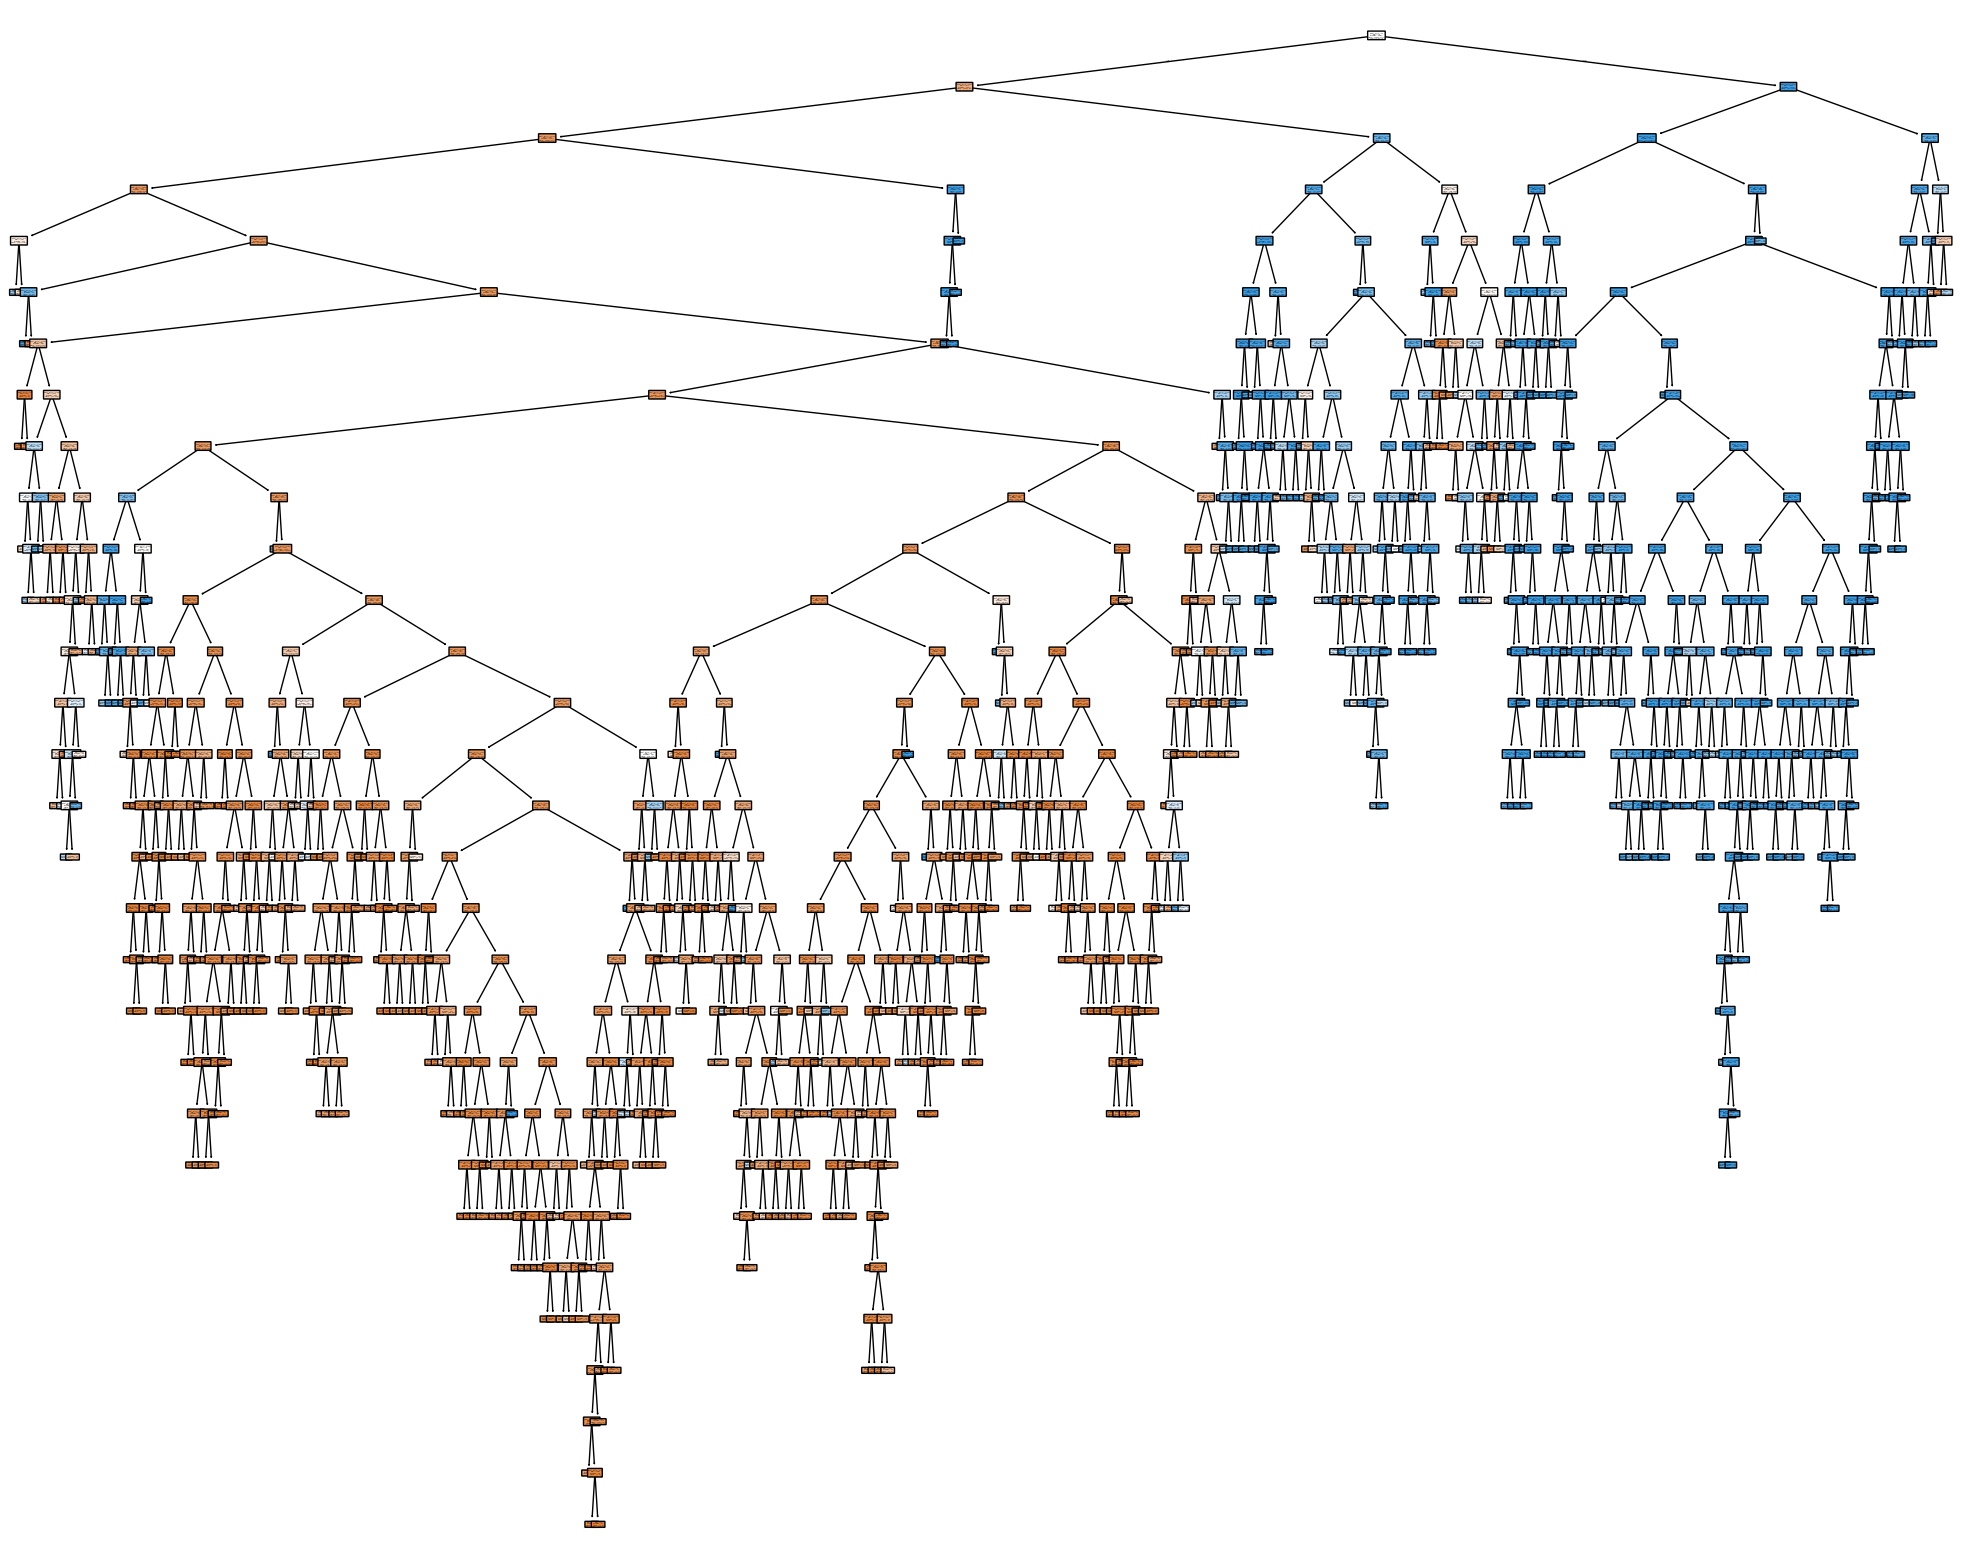

In [19]:
CT.plot_decision_tree(clf_gini, smart_features, ['No Failure', 'Failure'])

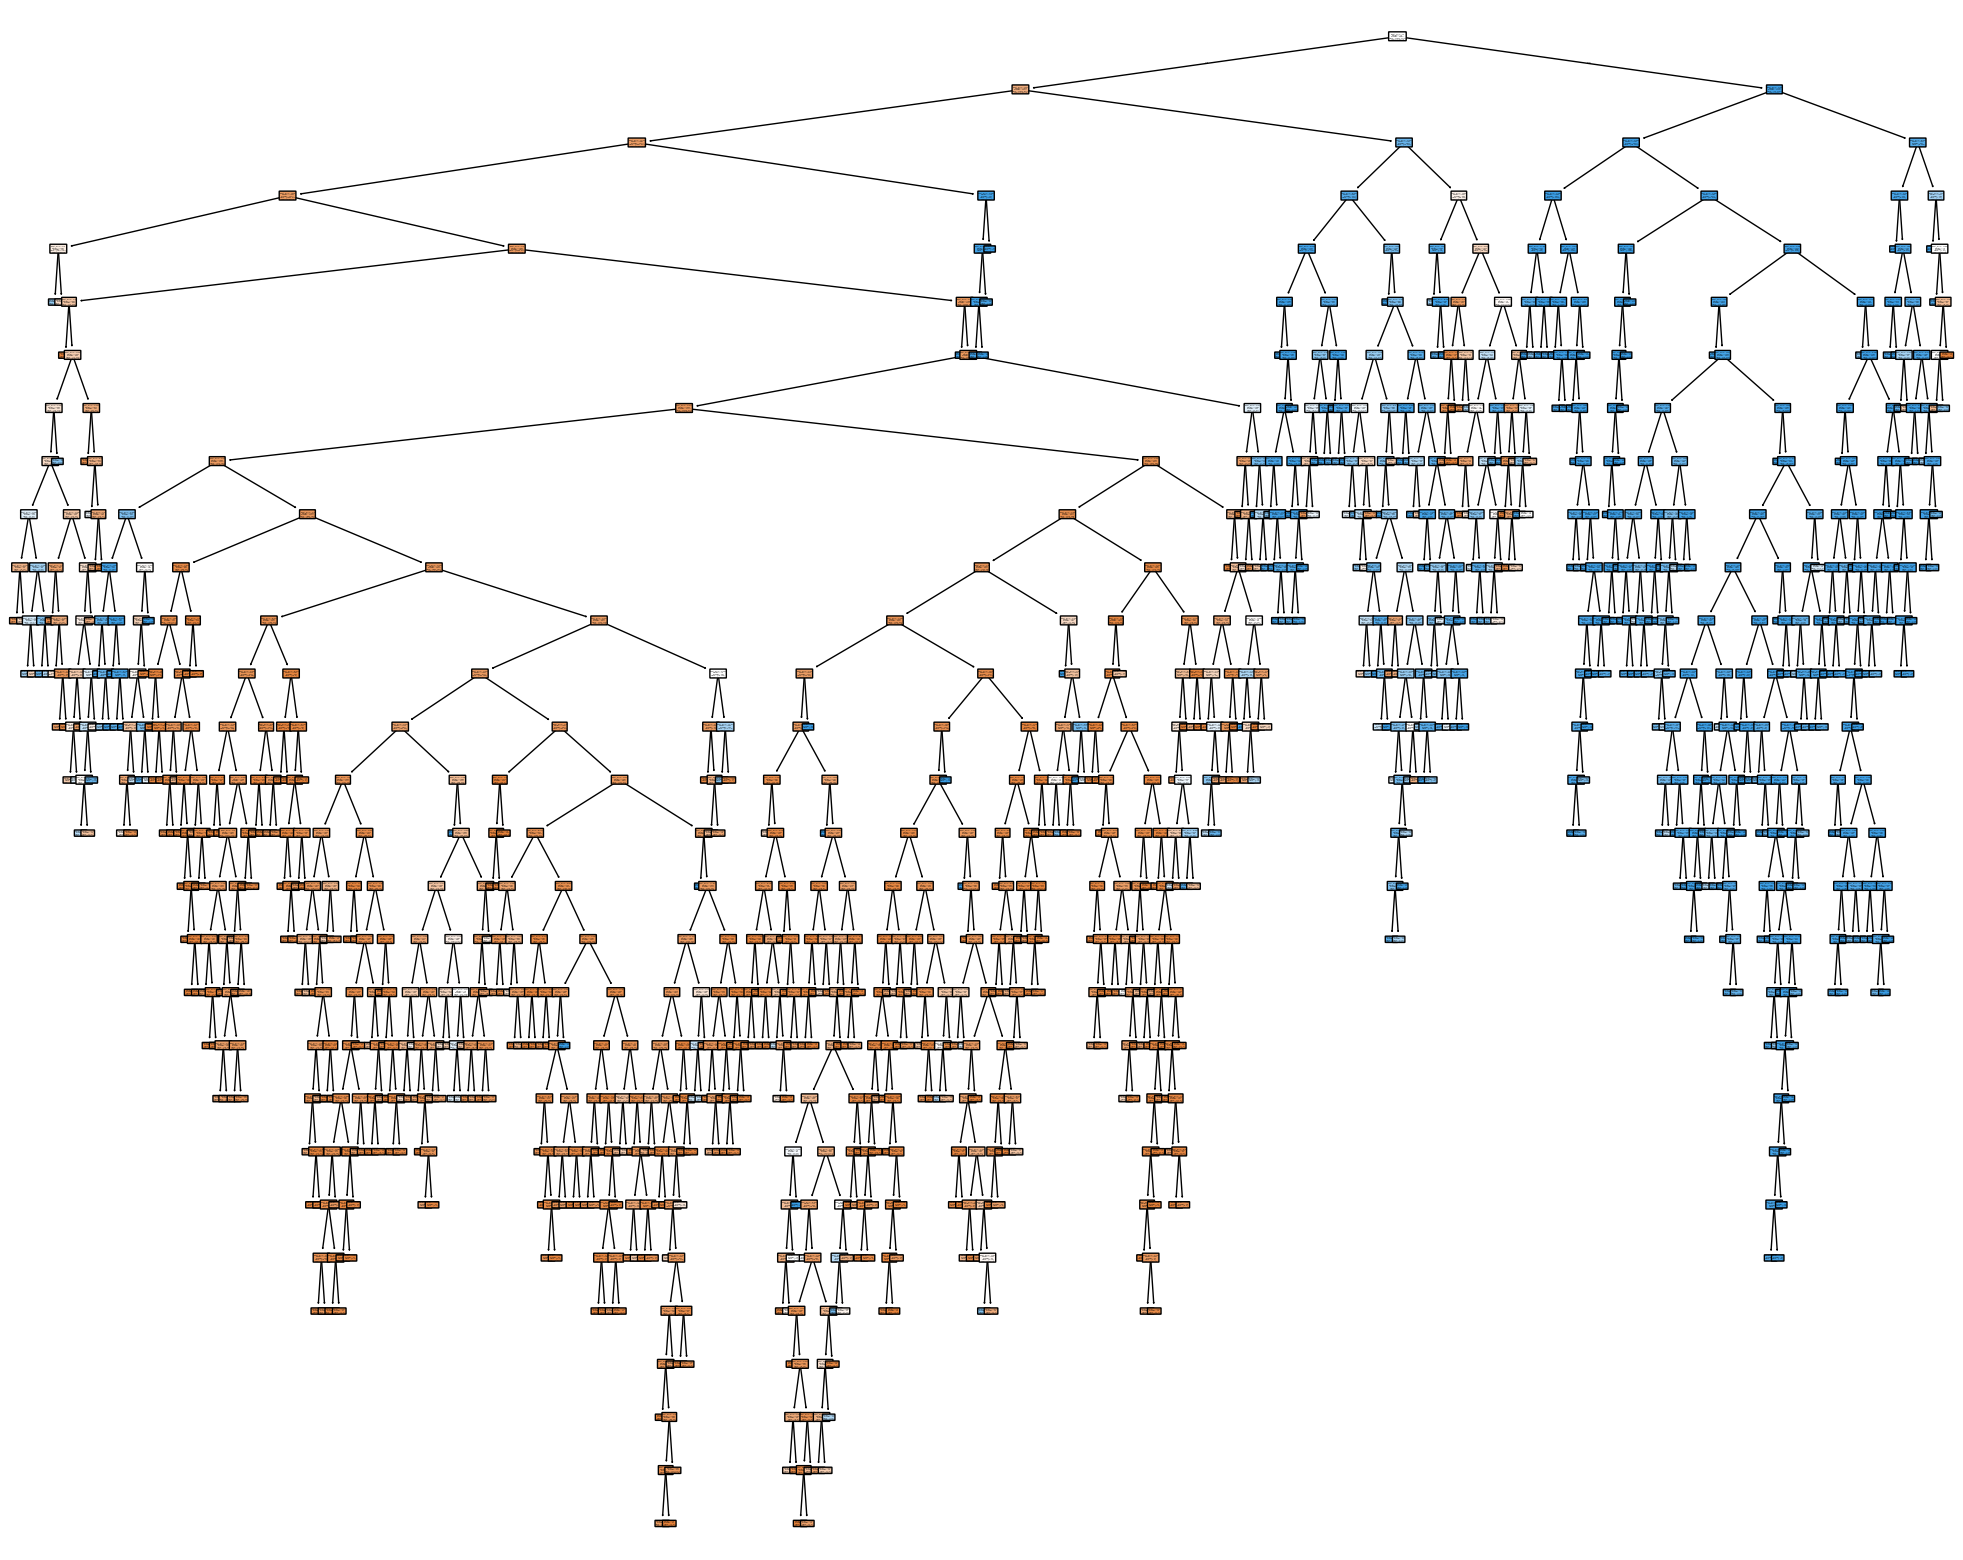

In [20]:
CT.plot_decision_tree(clf_entropy, smart_features, ['No Failure', 'Failure'])

### Now we will predict a hard drive with the lstm and consume it and classify the prediction result with the CT

In [21]:
path = "../data/data_test"
verbose = True    # Create a single data loader that handles the train/test split properly
model_path = 'models/LSTM/lstm_model.pth'
dataset_path = "../data/data_test"
output_path = "../pipeline/lstm_predictions_3drives_7days.csv"


We load all the data to choose randomly drives to generate predictions from

In [22]:
num_drives = 5 # We will drive only one drive for testing purposes
data_loader = smart.DriveDataLoader(root=path, 
                                train_ratio=0.01, # we are going to use only the testing data
                                min_sequence_length=min_sequence_length + 1,  # to have 1 day to test  
                                verbose=verbose, num_drives=num_drives)

[DriveDataLoader] Loading drives with at least 6 days of data...
[DriveDataLoader] Found 0 subfolders in ../data/data_test.


Loading CSV files:  17%|█▋        | 1/6 [00:03<00:17,  3.58s/it]

Loaded ../data/data_test\2024-10-01.csv with shape (292679, 15)


Loading CSV files:  33%|███▎      | 2/6 [00:07<00:14,  3.53s/it]

Loaded ../data/data_test\2024-10-02.csv with shape (292648, 15)


Loading CSV files:  50%|█████     | 3/6 [00:10<00:10,  3.47s/it]

Loaded ../data/data_test\2024-10-03.csv with shape (292662, 15)


Loading CSV files:  67%|██████▋   | 4/6 [00:13<00:06,  3.41s/it]

Loaded ../data/data_test\2024-10-04.csv with shape (292694, 15)


Loading CSV files:  83%|████████▎ | 5/6 [00:17<00:03,  3.40s/it]

Loaded ../data/data_test\2024-10-05.csv with shape (292693, 15)


Loading CSV files: 100%|██████████| 6/6 [00:20<00:00,  3.40s/it]

Loaded ../data/data_test\2024-10-06.csv with shape (292683, 15)
[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized', 'smart_9_normalized', 'smart_187_normalized', 'smart_189_normalized', 'smart_190_normalized', 'smart_195_normalized', 'smart_197_normalized', 'smart_197_raw']


[DriveDataLoader] Loaded 1756059 rows from all CSV files. DataFrame shape: (1756059, 15)
[DriveDataLoader] Selected 5 drives for processing.
[DriveDataLoader] Total rows in selected drives: 30


In [23]:
selected_drives = data_loader.get_all_data()

print(f"Loaded {len(selected_drives)} days from the dataset from {num_drives} drives.")


Loaded 30 days from the dataset from 5 drives.


In [24]:
# Extract the last day for each drive and store in a DataFrame
last_days_df = selected_drives.groupby('serial_number').tail(1).reset_index(drop=True)
print(last_days_df)

         date serial_number  failure  smart_1_normalized  smart_3_normalized  \
0  2024-10-06  6210A0QHFVKG    False                 100                 100   
1  2024-10-06      ZGG4HPHA    False                 100                  83   
2  2024-10-06      ZL22ZX61    False                  83                  91   
3  2024-10-06      ZL2CPA4Y    False                  72                  93   
4  2024-10-06      ZLW0G67X    False                  82                  90   

   smart_5_normalized  smart_5_raw  smart_7_normalized  smart_9_normalized  \
0                 100            0                 100                  58   
1                 100            0                 100                 100   
2                 100            0                  87                  75   
3                 100            0                  86                  67   
4                 100            0                  74                  58   

   smart_187_normalized  smart_189_normalized  sma

In [25]:
model_path = 'models/LSTM/lstm_model.pth'
model, model_metrics = smart.load_model(model_path, device, load_whole_model=True)

✅ Complete model loaded from models/LSTM/lstm_model.joblib
✅ Model metrics loaded from models/LSTM/lstm_model_metrics.json


In [26]:
model.eval()

Net(
  (lstm): LSTM(12, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=24, bias=True)
)

In [27]:
ct_feature_list = [
    'serial_number', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_5_raw',
    'smart_7_normalized', 'smart_9_normalized', 'smart_187_normalized',
    'smart_189_normalized', 'smart_190_normalized', 'smart_195_normalized',
    'smart_197_normalized', 'smart_197_raw'
]
predicted_info = pd.DataFrame(columns=ct_feature_list)

In [28]:

for serial, drive_df in tqdm(selected_drives.groupby('serial_number'), desc="Processing drives"):
    # Prepare your input sequence for the LSTM
    features = drive_df.drop(columns=['serial_number', 'date', 'failure']).values
    # Convert to tensor and add batch/sequence dimensions as needed, and use float64
    input_tensor = torch.tensor(features, dtype=torch.float64).unsqueeze(0)  # shape: [1, seq_len, features]
    # Run through model
    with torch.no_grad():
        prediction = model(input_tensor.to(device))
        last_day_pred = prediction[:, -1, :].cpu().numpy().flatten()
        # Map last_day_pred to ct_feature_list and append to predicted_info
        pred_row = dict(zip(ct_feature_list, last_day_pred))
        pred_row['serial_number'] = serial
        predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)

Processing drives:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Green\AppData\Local\Temp\ipykernel_15620\313099277.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)
Processing drives: 100%|██████████| 5/5 [00:00<00:00, 71.88it/s]


In [29]:
print(predicted_info)

  serial_number  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
0  6210A0QHFVKG           99.273760           99.901448            0.083744   
1      ZGG4HPHA           99.277400           99.904743            0.084348   
2      ZL22ZX61           95.121698          100.644906            7.974944   
3      ZL2CPA4Y           95.121698          100.644906            7.974944   
4      ZLW0G67X           95.121698          100.644906            7.974944   

   smart_5_raw  smart_7_normalized  smart_9_normalized  smart_187_normalized  \
0    99.357731           69.222424           17.205635             -0.184223   
1    99.360541           69.224986           17.208494             -0.183362   
2    88.383509           63.490517           61.740422             21.370746   
3    88.383509           63.490517           61.740422             21.370746   
4    88.383509           63.490517           61.740422             21.370746   

   smart_189_normalized  smart_190_normalize

In [30]:

clf_gini = load("models/DT/best_gini_tree.joblib")
clf_entropy = load("models/DT/best_entropy_tree.joblib")

In [31]:
serial_numbers = predicted_info['serial_number'].unique()
# predicted_info = predicted_info.drop(columns=['serial_number'])

In [32]:
# Only use the feature columns for prediction to avoid warnings
feature_cols = [
	'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_5_raw',
	'smart_7_normalized', 'smart_9_normalized', 'smart_187_normalized',
	'smart_189_normalized', 'smart_190_normalized', 'smart_195_normalized',
	'smart_197_normalized', 'smart_197_raw'
]
ct_predictions = CT.prediction(predicted_info[feature_cols].values, clf_gini)

# Add predictions to the DataFrame
predicted_info['CT_Drive_Failed'] = ct_predictions
print(predicted_info)


Predicted values:
[ True  True  True  True  True]
  serial_number  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
0  6210A0QHFVKG           99.273760           99.901448            0.083744   
1      ZGG4HPHA           99.277400           99.904743            0.084348   
2      ZL22ZX61           95.121698          100.644906            7.974944   
3      ZL2CPA4Y           95.121698          100.644906            7.974944   
4      ZLW0G67X           95.121698          100.644906            7.974944   

   smart_5_raw  smart_7_normalized  smart_9_normalized  smart_187_normalized  \
0    99.357731           69.222424           17.205635             -0.184223   
1    99.360541           69.224986           17.208494             -0.183362   
2    88.383509           63.490517           61.740422             21.370746   
3    88.383509           63.490517           61.740422             21.370746   
4    88.383509           63.490517           61.740422             21.37074

In [33]:

# Compare predicted failure with actual failure for each drive
last_days_df_sorted = last_days_df.set_index('serial_number').loc[serial_numbers].reset_index()
predicted_info['Actual_Failure'] = last_days_df_sorted['failure'].values

# Optionally, print a comparison summary
comparison = predicted_info[['CT_Drive_Failed', 'Actual_Failure']]
print("Prediction vs Actual Failure:\n", comparison)

print("accuracy:", (predicted_info['CT_Drive_Failed'] == predicted_info['Actual_Failure']).mean())



Prediction vs Actual Failure:
    CT_Drive_Failed  Actual_Failure
0             True           False
1             True           False
2             True           False
3             True           False
4             True           False
accuracy: 0.0
